## 9장 암과 싸워 이기기 위한 파이토치 활용

### 흉부 CT 스캔을 입력으로 받아 악성 종양을 자동으로 탐지하는 프로젝트
- 환자 몸통의 3차원 CT 스캔을 입력 받아서 악성 종양이 의심되는 경우 해당 위치를 출력
- 프로젝트의 성공적인 수행을 위해 무엇을 준비해야 하는지 (9~14장)
    - 훈련 루프 설정
    - 올바른 성능 지표 도출
    - 프로젝트 모델을 최종 애플리케이션으로 연결
- 8장에서 다룬 모델 구축 내용(해상도를 낮추는 다운샘플링, 반복되는 컨볼루션층)이 모델의 대부분을 구성
- 하지만, 앞선 예제와 달리 2차원 이미지가 아닌 3차원 데이터를 입력으로 사용
    - 모델 구축 이외의 부분에도 많은 노력 필요

#### 프로젝트 요구 사양
- 8GB 이상의 RAM을 갖춘 GPU
    - GPU가 없는 경우를 위해 14장에서 사전 훈련된 모델을 제공
    - Google Colab에서 제공하는 무료 GPU 인스턴스 사용 가능
- 원본 훈련 데이터와 캐시 데이터, 훈련된 모델을 저장하기 위한 220GB의 디스크 공간

#### 복셀(voxel)
- 면적이 아닌 공간 용적을 담고 있는 용적 픽셀 (VOlumetric piXEL)
- 2차원 데이터(이미지)를 이루는 2차원 픽셀의 3차원 버전
- 데이터 필드를 표현하기 위해 3차원 격자로 배열
- 복셀은 정육면체인 경우가 일반적이지만, 이번 프로젝트에서 다룰 복셀은 직육면체의 형태
- 환자의 머리부터 발끝까지를 축으로 단층 촬영하는 CT 특성상 전체 스캔이 직육면체이므로 복셀도 직육면체 형태
- 의학 분야 외에도 유체(fluid) 시뮬레이션, 2차원 이미지로부터 재구성된 3차원 장면, 자율주행차 LIDAR(light detection and ranging) 등에 사용

#### CT(Computed Tomography) 스캔 데이터
- 컴퓨터 단층촬영(CT) 스캔은 단일 채널의 3차원 배열로 표현되는 3차원 엑스레이 데이터
- 흑백 PNG 이미지를 차곡차곡 쌓아놓은 것과 흡사 (4장)
- CT 스캔 내의 각 복셀은 해당 위치에 있는 물체의 평균 질량 밀도를 나타내는 숫자 값을 의미
    - CT 스캔 등 3D 의료 이미지에서 특정 체적 내에서 조직의 엑스선 흡수율을 나타내기 위해 복셀 값을 사용
- 밀도가 높은 뼈나 금속 임플란트는 하얀색, 밀도가 낮은 공기나 폐 조직은 검은색, 지방이나 조직은 밝기가 다양한 회색
- X-ray는 3차원적인 강도(조직, 골밀도 등)를 2차원 평면에 투영(projection)한 것이지만, CT 스캔은 3차원 형태를 보존
    - 3차원 데이터 표현을 통해 관심 없는 조직을 숨겨 대상의 내부를 관찰 가능
    - ex) 데이터를 3차원으로 나타내고(rendering) 뼈와 폐 조직만 보이게 조정
- CT 스캔은 데이터가 디지털 포맷이라는 점에서 X-ray 데이터와의 또 다른 차이가 존재
    - 원본 출력은 육안으로 구별 가능한 형태가 아니므로 컴퓨터를 사용한 재해석 필요
- CT 좌표계 및 이미지 렌더링(rendering)
    - CT의 표준 렌더링은 기본적으로 머리가 위쪽을 향하도록 상체를 영상 맨 위에 배치
    - CT 단면의 배치 순서는 반대로 발이 먼저 위치
    - 이를 고려하여 뒤집어 주지 않으면 맵플롯립(matplotlib)에서 이미지를 거꾸로 렌더링
    - 상하 반전은 괜찮지만 이미지 렌더링 과정에서는 제대로 방향을 맞추어야 하므로 뒤집는 코드 삽입


#### CT 스캔 작동 원리
- 엑스선 발생
    - CT 스캔은 엑스선 발생 튜브와 엑스선 감지 디텍터를 사용하는 기계로 구성
    - 튜브가 환자를 중심으로 회전하며 엑스선을 생성
- 엑스선 투과
    - 생성된 엑스선을 환자의 몸에 투과시키면 일부 엑스선은 환자의 몸에 흡수되고 일부는 디텍터에 도달
    - 환자의 다양한 조직(뼈, 근육, 지방 등)은 엑스선을 다르게 흡수하므로 이러한 차이를 활용하여 이미지를 생성
- 이미지 생성
    - 엑스선 튜브는 환자를 둘러싸고 회전하며 수천 개의 다른 각도에서 엑스선 이미지를 캡처
    - 이러한 데이터는 컴퓨터에 의해 처리되어 환자의 몸을 수평으로 잘랐을 때의 이미지를 제공
    - 환자의 내부를 세밀하게 검토할 때 유용하게 사용
- 3D 이미지 생성
    - 필요에 따라 개별 슬라이스들을 결합하여 환자의 몸의 3D 이미지를 생성

#### 종양(tumor)과 결절(nodule)
- 종양은 증식하는 세포로 이루어진 조직 덩어리를 의미
    - 양성(benign) 또는 악성(maligant)으로 나뉘며, 악성인 경우가 암(cancer)
- 폐에 있는 작은 종양을 폐 결절(lung nodule)이라고 하며, 폐 결절의 약 40%는 악성

#### 엔드투엔드(end-to-end) 폐암 진단기
- E2E(end-to-end) 학습 방식
    - 입력에서 출력까지 중간 단계의 파이프라인 네트워크 없이 하나의 신경망으로 한 번에 처리 [[link](https://www.youtube.com/watch?v=ImUoubi_t7s&t=54s)]
- 흉부 CT 스캔 조사부터 환자에게 폐암 진단을 내리기까지(end-to-end solution) 총 5가지 주요 단계
    - CT 데이터 파일을 읽어서 CT 인스턴스 생성
    - 전체 3차원 스캔 데이터를 담고 세그멘테이션(segmentation; 관심 있는 복셀을 표시)을 수행하는 모듈과 결합
    - 추려진 복셀을 작은 덩어리로 나누어 결절(nodule)로 간주될 만한 것을 찾아서 추출
    - 결절의 위치 정보를 CT 복셀 데이터 뒤에 이어붙여 후보군 데이터 생성
    - 결절을 분류하는 모델을 통해 후보군이 애초부터 실제 결절인지, 최종적으로 악성이 될지 여부를 조사
    - 각각의 결졀별 분류 결과를 환자 진단 결과로 병합
- 3, 4단계에서 훈련에 사용하는 데이터는 전문가들이 직접 확인하고 표기한 정답을 제공
    - 2, 3단계(각 복셀을 확인하고 결절 후보군으로 그룹화)와 4단계(결절 후보 분류)를 순서 상관없이 개별로 진행 가능
    - 1단계에서 데이터 확보하고 4단계를 먼저 진행한 후 분류 모델을 조작할 단계가 되면 2, 3단계로 돌아와 구현
    - 선형 분류기에 넣기 전에 4단계에서 다중 컨볼루션층과 풀링층을 통해 공간 정보를 누적 (8장)
- 실제 진행 순서
    - 1단계: 데이터 불러오기
    - 4단계: 결절 분류
    - 2단계: 세그멘테이션
    - 3단계: 그룹화
    - 5단계: 결절 분석 및 진단

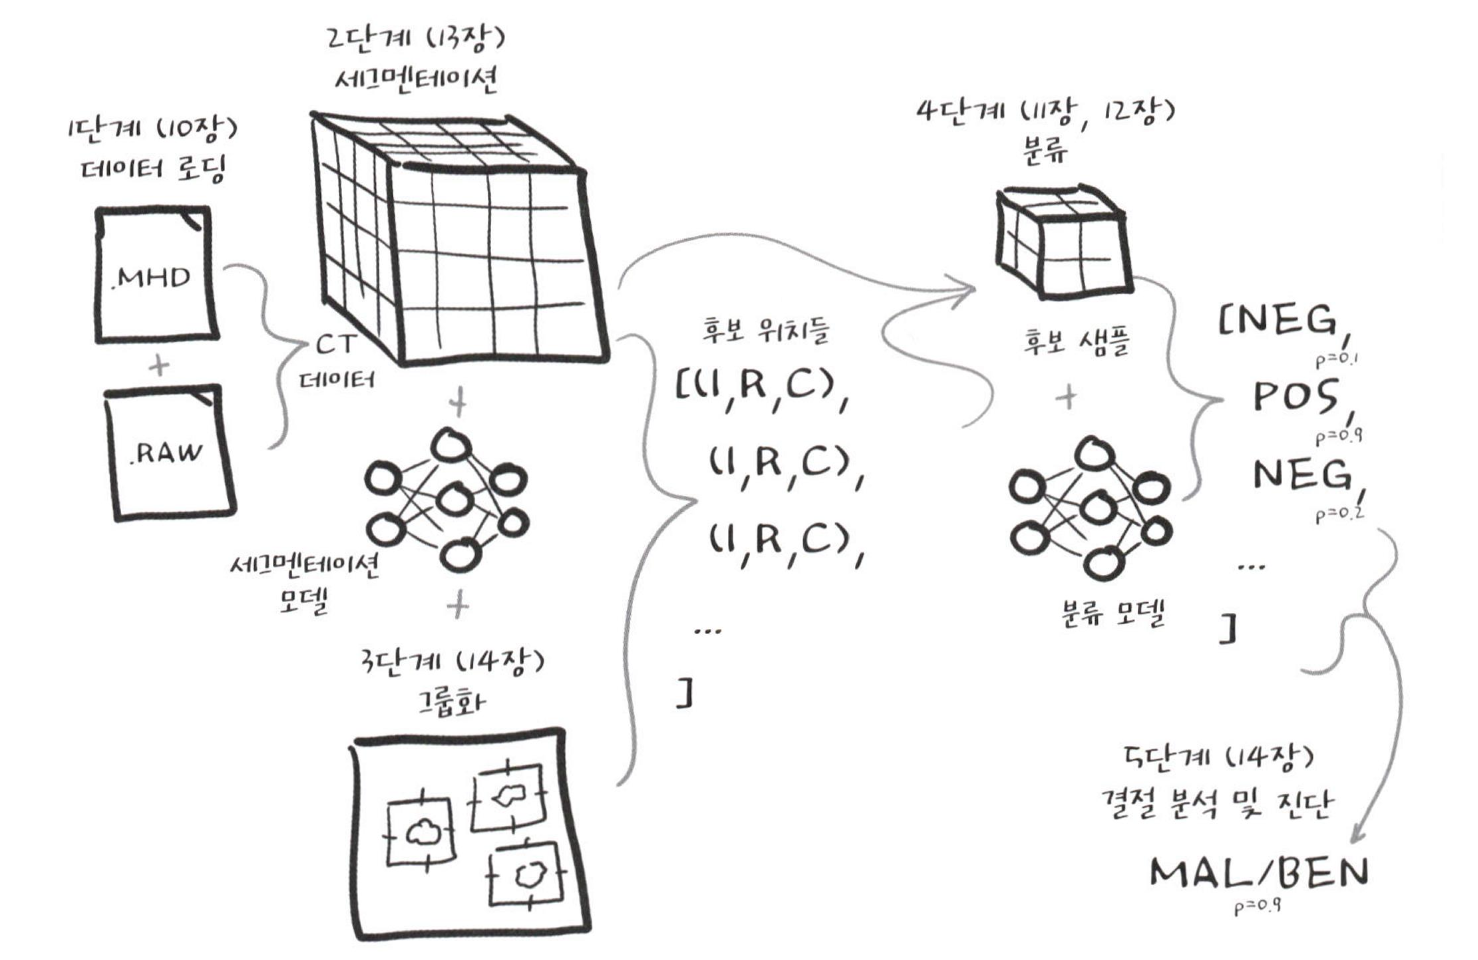

#### 5단계 프로세스
1) 원본 CT 스캔 데이터를 파이토치로 사용할 수 있는 형태로 불러오기
2) 세그멘테이션(segmentation) 기술 구현을 위해 파이토치를 사용하여 폐의 잠재적 결절에 해당하는 복셀을 추출
    - 히트맵(heatmap) 작성과 유사한 작업
    - 세그멘테이션을 통해 찾은 복셀을 3번 단계의 분류기(classifier)에서 사용
    - 이 작업을 통해 관심 없는 해부학적 부위는 무시하고 폐 내부의 잠재적 종양에 집중
3) 관심 있는 복셀들을 덩어리(후보 결절)로 그룹화 (딥러닝 불필요)
    - 그룹화된 데이터는 종양(판별이 어렵거나 잠재적 악성 가능성이 있는 종양)에 대한 연속적인 CT 단면
    - 히트맵에서 significant voxels의 개략적인 중심부를 찾는 과정
    - 각각의 결절에 인덱스가 부여되므로 중심부에서 시작하는 열과 행으로 위치 파악 가능
    - 이렇게 제약을 가해 단순해진 문제를 최종 분류기에 전달
4) 3차원 컨볼루션을 사용하여 각 후보 결절에 대해 실제 결절인지 아닌지 분류
    - 8장에서 다룬 2차원 컨볼루션 개념과 흡사
    - 후보 구조로부터 종양 여부를 결정하는 특성은 종양 진단에 국한된 문제이므로 필터링 수행
    - 입력 데이터를 너무 많이 필터링하여 중요한 정보까지 버려지지 않도록 적절한 균형 필요
5) 각 결절별로 분류한 결과를 종합하여 환자를 진단
    - 영상 데이터만을 가지고 결절이 양성인지 악성인지 판별 (이전 단계의 결절 분류기와 유사)
    - 결절별 악성 예측을 구한 후 이들의 최댓값을 사용하는 방식으로 하나라도 악성이 예측되면 해당 환자를 암으로 진단
    - 의심스러운 부분이 하나라도 있는지 확인하는 목적이므로 단순하게 최댓값을 집계

#### 결절(nodule)
- 폐 내부에서 나타날 수 있는 무수한 돌기나 덩어리를 의미
- 종류에 따라서 환자의 견강에 문제가 될 수도 있고 아닌 경우도 존재
- 정의에 의하면 결절은 3cm 이하이며, 이보다 큰 경우는 폐 종괴(lung mass)
    - 프로젝트에서는 편의상 결절과 동일한 해부학적 구조(폐에 있는 작은 덩어리)를 보이면 모두 결절이라고 판단
- 결절은 양성 종양 또는 악성 종양으로 구분
- 방사선학 관점에서 결절은 감염이나 염증, 혈액 공급 이상, 기형적 혈관, 종양 이외의 질환 등 다양한 원인으로 발생
- 프로젝트에서 찾아내고자 하는 암은 항상 결절의 형태이며, 결절은 밀도가 매우 낮은 폐 조직에 매달려 있거나 폐 벽에 붙어 있을 것으로 추정
    - 따라서 분류기는 모든 조직을 검사할 필요 없이 예상 입력 범위를 좁혀서 결절만 집중적으로 학습 (도메인 지식 기반)
- 크기가 큰 결절도 있지만, 모델을 통해 찾고자 하는 결절의 최소 크기는 몇 밀리미터에 불과
- 가장 작은 결절은 대략 전체 CT 스캔의 수백만 분의 일 정도로 매우 작으며, 환자에게서 발견된 결절의 절반 이상은 악성이 아닌 양성

#### LUNA 그랜드 챌린지 데이터셋
- 폐 결절 분석 LUNA(LUng Nodule Analysis) 그랜드 챌린지에 사용된 CT 스캔 공개 데이터셋
- LUNA 데이터는 깨끗한 편이지만, 다른 데이터 소스를 다룰 때는 추가적으로 고려해야 할 문제들이 존재
- 실제 현장에서 사용되는 CT 스캔은 다양한 스캔 장비와 처리 프로그램 간 방식의 차이로 인해 처리가 복잡한 경우가 대부분
    - ex) 스캐너의 복셀 밀도가 음의 값으로 설정되어 CT 스캔 영역이 대상 영역 밖으로 지정되는 경우
    - 스캐너의 다양한 설정에 따라 아주 민감하게 혹은 매우 거칠게 잡히기도 하는 것이 CT 스캔 데이터의 특성
- 프로젝트에는 LUNA 2016 데이터셋 사용 [[link](https://luna16.grand-challenge.org/Download/)]